# Событийная аналитика. Анализ пользовательского поведения в мобильном приложении

Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения. 

Мы получили лог событий с проведенным A/A/B-экспериментом. Необходимо его исследовать. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Необходимо выяснить, какой шрифт лучше. 


## Описание данных

Каждая запись в логе — это действие пользователя, или событие.
* `EventName` — название события;
* `DeviceIDHash` — уникальный идентификатор пользователя;
* `EventTimestamp` — время события;
* `ExpId` — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.


## Загрузка данных и предобработка

### Подготовка к исследованию

In [1]:
# Подключение необходимых библиотек
import pandas as pd
import seaborn as sns
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as st
from matplotlib import cm
from plotly import graph_objects as go
import plotly.express as px
import math as mth

# Настройка общего вида графиков seaborn
sns.set(rc={"figure.dpi":100, 'savefig.dpi':300})
sns.set_context('notebook')
sns.set_style("ticks")
sns.set_theme(style="darkgrid")
sns.set_color_codes("pastel")

# Увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

In [2]:
import plotly.io as pio
png_renderer = pio.renderers["png"]
png_renderer.width = 900
png_renderer.height = 700

pio.renderers.default = "png"

In [3]:
#Импорт входных данных
try:
    df_logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')
    
except FileNotFoundError:
    df_logs = pd.read_csv('logs_exp.csv', sep='\t')

#поменяем вывод float значений
pd.set_option('display.float_format', lambda x: '%.2f' % x)

Напишем стандартную функцию общего обзора данных.

In [4]:
# Функция вывода красивых таблиц
def nice_display(data, rows_num):
    print(f"Первые {rows_num} строк таблицы".center(127, "-"))
    display(data.head(rows_num).style.set_table_styles(
        [{'selector': 'tr:nth-of-type(odd)',
          'props': [('background', '#eee')]},
         {'selector': 'tr:nth-of-type(even)',
            'props': [('background', 'white')]},
            {'selector': 'th',
             'props': [('background', '#2DA679'),
                       ('color', 'white'),
                       ('font-family', 'verdana')]},
            {'selector': 'td',
             'props': [('font-family', 'verdana')]},
         ]
    ).hide_index())

In [5]:
# Стандартная функция общего обзора данных
def data_view(data):
    print("Общая структура данных".center(127, "-") + '\n')
    display(data.info())
    print(127 * '-' + '\n')
    print("Первые 10 строк таблицы".center(127, "-"))
    display(data.head(10).style.set_table_styles(
        [{'selector': 'tr:nth-of-type(odd)',
          'props': [('background', '#eee')]},
         {'selector': 'tr:nth-of-type(even)',
            'props': [('background', 'white')]},
            {'selector': 'th',
             'props': [('background', '#2DA679'),
                       ('color', 'white'),
                       ('font-family', 'verdana')]},
            {'selector': 'td',
             'props': [('font-family', 'verdana')]},
         ]
    ).hide_index())
    print(127 * '-' + '\n')
    print("Доля пропущенных значений по столбцам в таблице".center(127, "-"))
    display(data.isna().mean().sort_values(ascending=False))
    print(127 * '-' + '\n')
    print('Визуализируем пропущенные значения графиком'.center(127, "-"))
    sns.heatmap(data.isna(), yticklabels=False, cbar=False, cmap="YlGnBu");
    plt.show()
    print(127 * '-' + '\n')
    print(f"Количество полных дубликатов: {data.duplicated().sum()}\n")
    print(127 * '-' + '\n')
    print("Статистическая информация о числовых данных".center(127, "-"))
    display(data.describe())
    print(127 * '-' + '\n')

In [6]:
# функция перевода списка строк из регистра Camel в змеиный
def camel_to_snake(s_list):
    new_list = []
    for s in s_list:
        new_list.append(''.join(['_'+c.lower() if c.isupper() else c for c in s]).lstrip('_'))
    return new_list

### Обзор и предобработка данных

Изучим файл с логами.

-----------------------------------------------------Общая структура данных----------------------------------------------------

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


None

-------------------------------------------------------------------------------------------------------------------------------

----------------------------------------------------Первые 10 строк таблицы----------------------------------------------------


EventName,DeviceIDHash,EventTimestamp,ExpId
MainScreenAppear,4575588528974610257,1564029816,246
MainScreenAppear,7416695313311560658,1564053102,246
PaymentScreenSuccessful,3518123091307005509,1564054127,248
CartScreenAppear,3518123091307005509,1564054127,248
PaymentScreenSuccessful,6217807653094995999,1564055322,248
CartScreenAppear,6217807653094995999,1564055323,248
OffersScreenAppear,8351860793733343758,1564066242,246
MainScreenAppear,5682100281902512875,1564085677,246
MainScreenAppear,1850981295691852772,1564086702,247
MainScreenAppear,5407636962369102641,1564112112,246


-------------------------------------------------------------------------------------------------------------------------------

----------------------------------------Доля пропущенных значений по столбцам в таблице----------------------------------------


EventName        0.00
DeviceIDHash     0.00
EventTimestamp   0.00
ExpId            0.00
dtype: float64

-------------------------------------------------------------------------------------------------------------------------------

------------------------------------------Визуализируем пропущенные значения графиком------------------------------------------


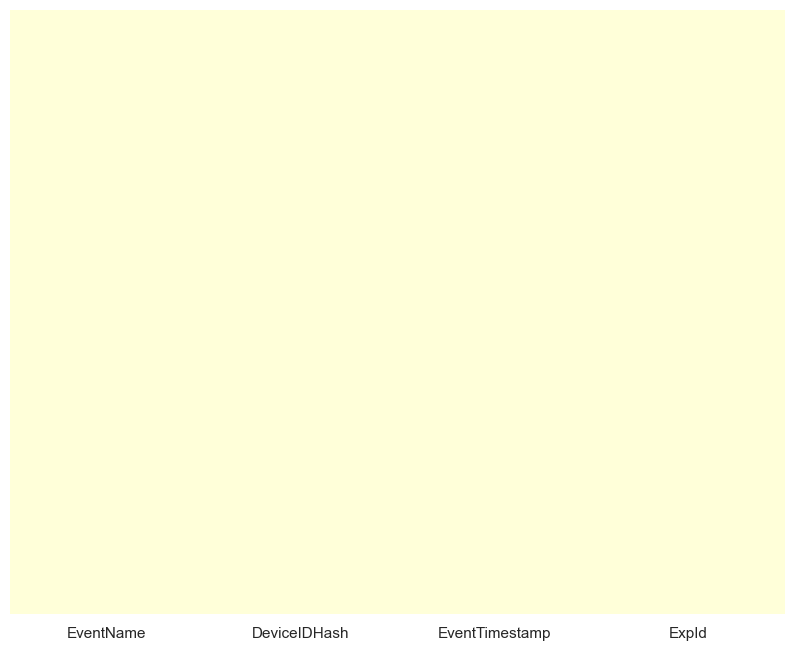

-------------------------------------------------------------------------------------------------------------------------------

Количество полных дубликатов: 413

-------------------------------------------------------------------------------------------------------------------------------

------------------------------------------Статистическая информация о числовых данных------------------------------------------


,DeviceIDHash,EventTimestamp,ExpId
count,244126.00,244126.00,244126.00
mean,4627568124591259648.00,1564913915.84,247.02
std,2642424998963961856.00,177134.32,0.82
min,6888746892508752.00,1564029816.00,246.00
25%,2372212476992240640.00,1564756580.25,246.00
50%,4623191541214045184.00,1564919395.00,247.00
75%,6932517045703054336.00,1565074511.00,248.00
max,9222603179720523776.00,1565212517.00,248.00


-------------------------------------------------------------------------------------------------------------------------------



In [7]:
data_view(df_logs)

#### Переименование столбцов

Для начала переведем названия столбцов в змеиный регистр для удобства.

In [8]:
df_logs.columns = camel_to_snake(df_logs.columns)
df_logs = df_logs.rename(columns={'device_i_d_hash': 'device_id_hash'})
df_logs.columns

Index(['event_name', 'device_id_hash', 'event_timestamp', 'exp_id'], dtype='object')

#### Обработка дубликатов

Удалим дубликаты (выше мы показали, что таких дубликатов 413).

In [9]:
df_logs = df_logs.drop_duplicates()

Также проверим, что у нас нет двух одинаковых идентификаторов пользователя в разных группах теста. Иначе, это может исказить дальнейший анализ.

In [10]:
# подсчет количества уникальных групп теста для каждого пользователя
t = df_logs.groupby('device_id_hash', as_index=False)['exp_id'].nunique()
t

,device_id_hash,exp_id
0,6888746892508752,1
1,6909561520679493,1
2,6922444491712477,1
3,7435777799948366,1
4,7702139951469979,1
...,...,...
7546,9217594193087726423,1
7547,9219463515465815368,1
7548,9220879493065341500,1
7549,9221926045299980007,1


In [11]:
# Проверка, что количество групп не больше 1
t.query('exp_id > 1')

,device_id_hash,exp_id


Таких пользователей не нашлось.

#### Преобразование типа столбца `timestamp` 

Преобразуем тип данных времени в тип `datetime`. Отметим, что в таблице время задано в секундах в формате Unix. Заодно выведем наш исследуемый диапазон времени.

In [12]:
df_logs['event_timestamp'] = pd.to_datetime(df_logs['event_timestamp'], unit='s')
print(f'Минимальное время в таблице {df_logs["event_timestamp"].min()}',
     f'\nМаксимальное время в таблице {df_logs["event_timestamp"].max()}')

Минимальное время в таблице 2019-07-25 04:43:36 
Максимальное время в таблице 2019-08-07 21:15:17


Добавим столбец с датой для дальнейшего удобства.

In [13]:
df_logs['event_date'] = pd.to_datetime(df_logs['event_timestamp'].dt.date)
nice_display(df_logs, 10)

----------------------------------------------------Первые 10 строк таблицы----------------------------------------------------


event_name,device_id_hash,event_timestamp,exp_id,event_date
MainScreenAppear,4575588528974610257,2019-07-25 04:43:36,246,2019-07-25 00:00:00
MainScreenAppear,7416695313311560658,2019-07-25 11:11:42,246,2019-07-25 00:00:00
PaymentScreenSuccessful,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 00:00:00
CartScreenAppear,3518123091307005509,2019-07-25 11:28:47,248,2019-07-25 00:00:00
PaymentScreenSuccessful,6217807653094995999,2019-07-25 11:48:42,248,2019-07-25 00:00:00
CartScreenAppear,6217807653094995999,2019-07-25 11:48:43,248,2019-07-25 00:00:00
OffersScreenAppear,8351860793733343758,2019-07-25 14:50:42,246,2019-07-25 00:00:00
MainScreenAppear,5682100281902512875,2019-07-25 20:14:37,246,2019-07-25 00:00:00
MainScreenAppear,1850981295691852772,2019-07-25 20:31:42,247,2019-07-25 00:00:00
MainScreenAppear,5407636962369102641,2019-07-26 03:35:12,246,2019-07-26 00:00:00


In [14]:
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   event_name       243713 non-null  object        
 1   device_id_hash   243713 non-null  int64         
 2   event_timestamp  243713 non-null  datetime64[ns]
 3   exp_id           243713 non-null  int64         
 4   event_date       243713 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 11.2+ MB


### Вывод

В этой части мы загрузили и предобработали данные.
* Удалили полные дубликаты в данных;
* Изменили названия столбцов на более удобные;
* Привели данные к необходимому типу и добавили столбец с датой события для удобства;
* Убедились, что в разных экспериментах нет одинаковых пользователей - значит данные об экспериментах собраны верно.

## Анализ данных

### Изучение данных

Соберем общую информацию о данных в нашем логе. Создадим таблицу, в которую будем добавлять общую информацию о данных.

In [15]:
# Функция создания таблицы с результатами
def data_info(logs):
    result_info = pd.DataFrame(columns=['info', 'result'])
    result_info.loc[0, 'info'] = 'Всего событий'
    result_info.loc[1, 'info'] = 'Всего пользователей'
    result_info.loc[2, 'info'] = 'В среднем событий на пользователя'
    result_info.loc[3, 'info'] = 'Медианное количество событий на пользователя'
    result_info.loc[4, 'info'] = 'Минимальное время в логах'
    result_info.loc[5, 'info'] = 'Максимальное время в логах'
    result_info.loc[6, 'info'] = 'Общая продолжительность доступных данных'
    result_info.loc[0, 'result'] = logs['event_name'].count()
    result_info.loc[1, 'result'] = logs['device_id_hash'].nunique()
    result_info.loc[2, 'result'] = int(logs.groupby('device_id_hash')['event_name'].count().mean())
    result_info.loc[3, 'result'] = int(logs.groupby('device_id_hash')['event_name'].count().median())
    result_info.loc[4, 'result'] = logs['event_timestamp'].min()
    result_info.loc[5, 'result'] = logs['event_timestamp'].max()
    result_info.loc[6, 'result'] = logs['event_timestamp'].max()  - logs['event_timestamp'].min()
    return result_info

In [16]:
nice_display(data_info(df_logs), 7)

-----------------------------------------------------Первые 7 строк таблицы----------------------------------------------------


info,result
Всего событий,243713
Всего пользователей,7551
В среднем событий на пользователя,32
Медианное количество событий на пользователя,20
Минимальное время в логах,2019-07-25 04:43:36
Максимальное время в логах,2019-08-07 21:15:17
Общая продолжительность доступных данных,13 days 16:31:41


### Анализ количества событий

Посмотрим на количество событий в каждую доступную дату из логов.

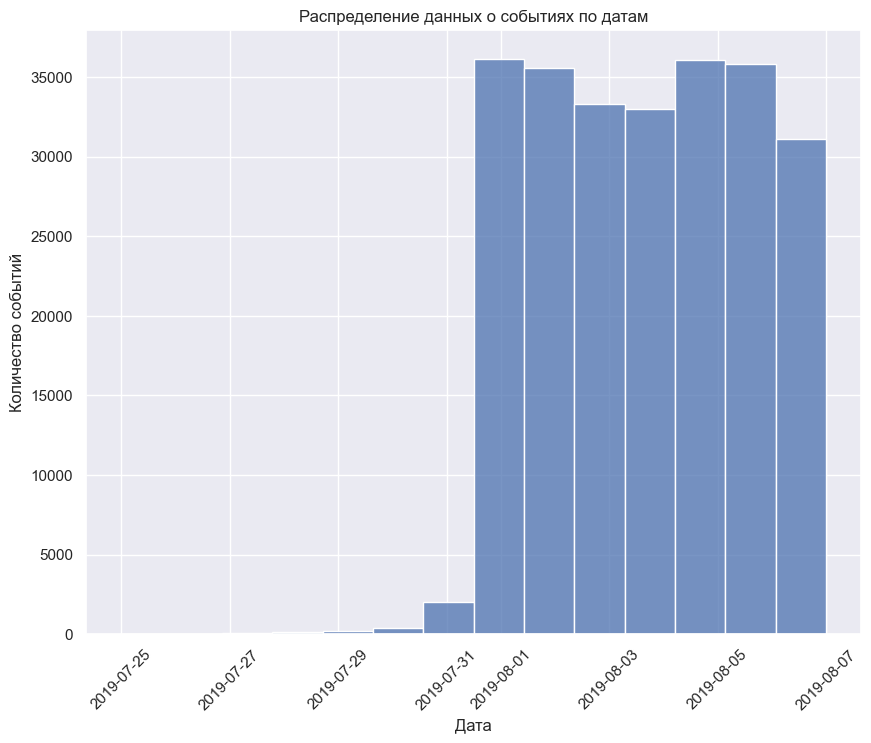

In [17]:
sns.histplot(data=df_logs, x='event_date', bins=14)
plt.ylabel('Количество событий')
plt.title('Распределение данных о событиях по датам')
plt.xticks(rotation=45)
plt.xlabel('Дата');

Также, посмотрим на распределение событий во времени для более подробной картины.

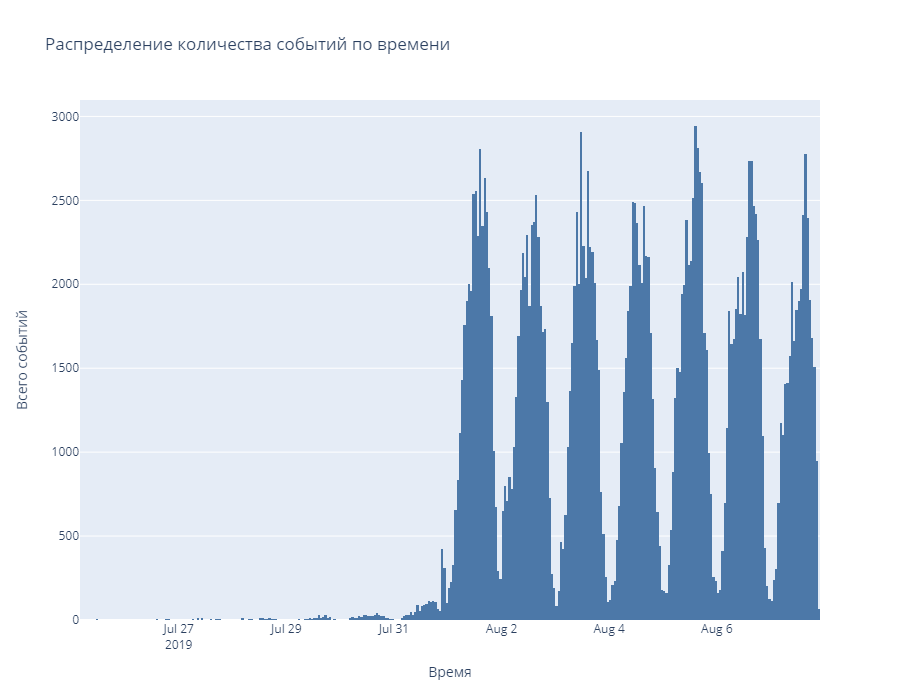

In [18]:
fig = px.histogram(df_logs, x="event_timestamp", labels={
                   'event_timestamp': 'Время', 'count': 'Всего событий'}, title='Распределение количества событий по времени',
                  color_discrete_sequence=px.colors.qualitative.T10)
fig.update_layout(yaxis_title="Всего событий")
fig.show()

Посмотрим на распределение количества событий для каждой группы эксперимента по датам.

In [19]:
df_logs_date = df_logs.groupby(['event_date', 'exp_id'], as_index=False).agg(
    {'event_name': 'count', 'device_id_hash': 'nunique'})
df_logs_date = df_logs_date.rename(columns={'event_name': 'events_count', 'device_id_hash': 'unique_devices'})

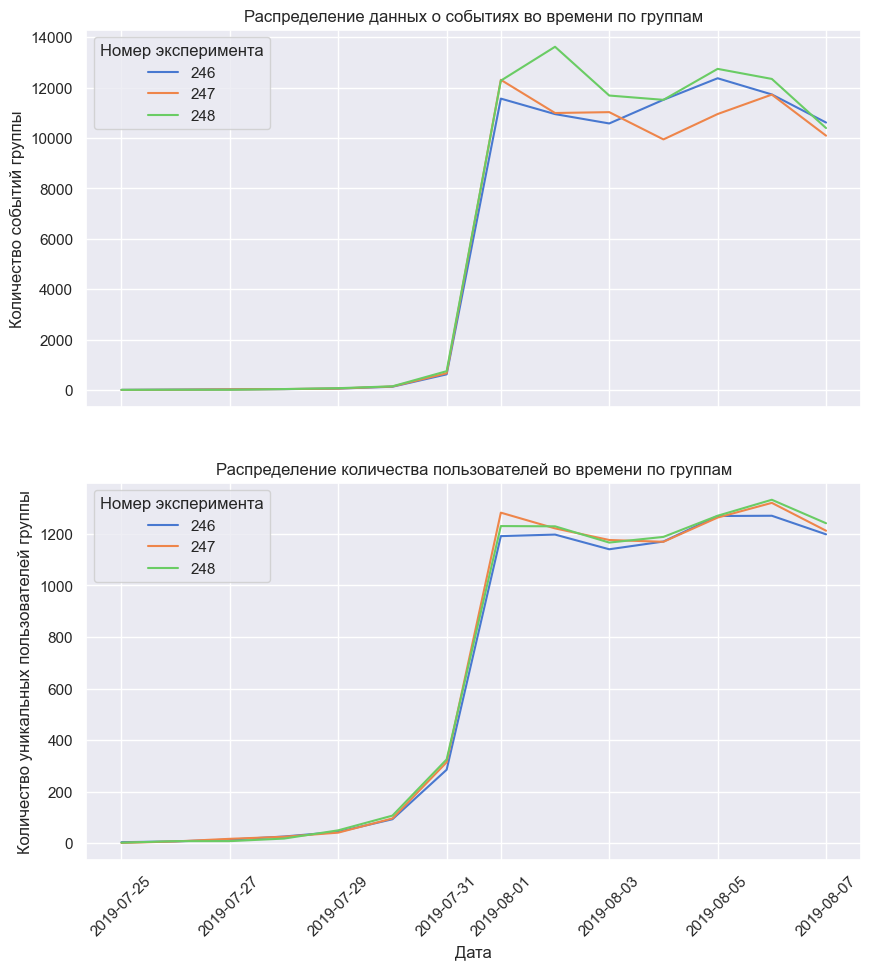

In [20]:
sns.set(rc={'figure.figsize':(10,11)})
fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True)
ax1 = plt.subplot(2, 1, 1)
sns.lineplot(data=df_logs_date, x='event_date', y='events_count', hue='exp_id', palette='muted')
plt.ylabel('Количество событий группы')
plt.title('Распределение данных о событиях во времени по группам')
plt.legend(title='Номер эксперимента')

ax2 = plt.subplot(2, 1, 2)
sns.lineplot(data=df_logs_date, x='event_date', y='unique_devices', hue='exp_id', palette='muted')
plt.xticks(rotation=45)
plt.xlabel('Дата')
plt.ylabel('Количество уникальных пользователей группы')
plt.title('Распределение количества пользователей во времени по группам')
plt.legend(title='Номер эксперимента');

Видно, что в первые дни эксперимента данных мало: основной массив данных приходится на  период с `01-08-2019`. Данные за предыдуший период будут мешать, лучше их отфильтровать.

Отфильтруем эти данные и посмотрим на общую информацию по уже отфильтрованным данным. Для наглядности добавим предыдущий общий анализ и посчитаем долю потерянных данных.

In [21]:
df_logs_filtered = df_logs.query('event_date >= 20190801')

In [22]:
compare_data = data_info(df_logs)
compare_data['new_result'] = data_info(df_logs_filtered)['result']
compare_data.loc[:1, 'loss_ratio'] = (
    (compare_data.loc[:1, 'result'] - compare_data.loc[:1, 'new_result']) / 
    compare_data.loc[:1, 'result'] * 100).astype(float).round(2).map('{:,.2f}%'.format)
nice_display(compare_data, 7)

-----------------------------------------------------Первые 7 строк таблицы----------------------------------------------------


info,result,new_result,loss_ratio
Всего событий,243713,240887,1.16%
Всего пользователей,7551,7534,0.23%
В среднем событий на пользователя,32,31,nan
Медианное количество событий на пользователя,20,19,nan
Минимальное время в логах,2019-07-25 04:43:36,2019-08-01 00:07:28,nan
Максимальное время в логах,2019-08-07 21:15:17,2019-08-07 21:15:17,nan
Общая продолжительность доступных данных,13 days 16:31:41,6 days 21:07:49,nan


### Анализ воронки событий

Посмотрим какой набор событий присутствует в наших логах.

In [23]:
df_logs_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Tutorial                     1005
Name: event_name, dtype: int64

Получили набор из 5 событий:
* Самое популярное событие `MainScreenAppear` - показ главного экрана;
* Второе по популярности `OffersScreenAppear` - показ экрана заказа;
* Третье `CartScreenAppear` - показ экрана с корзиной;
* Четвертое `PaymentScreenSuccessful` - показ экрана успешной оплаты;
* Самое редкое событие `Tutorial` - судя по названию это прохождение обучения интерфейсу. 

Событие `Tutorial` напрямую не может влиять на то, купит или не купит ли пользователь продукт. Это, в том числе, подтверждает то, что это событие самое редкое, намного реже, чем событие успешной оплаты. Поэтому от таких записей можно избавиться.

In [24]:
# Удаление записей с событием Tutorial
df_logs_filtered = df_logs_filtered.query('event_name != "Tutorial"').copy()
df_logs_filtered['event_name'].value_counts()

MainScreenAppear           117328
OffersScreenAppear          46333
CartScreenAppear            42303
PaymentScreenSuccessful     33918
Name: event_name, dtype: int64

Покажем у какого количества пользователей появлялось каждое из этих событий. Посчитаем долю событий во всех данных. Не будем учитывать повторяющиеся события у одного пользователя.

In [25]:
# Общее количество пользователей
total_users = int(df_logs_filtered['device_id_hash'].nunique())

# Группировка по типу события
events_grouped = df_logs_filtered.groupby(['event_name'], as_index=False).agg(
    {'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
events_grouped.columns = ['event_name', 'id_count']
events_grouped['initial_ratio'] = (events_grouped['id_count'] / total_users * 100).map('{:,.2f}%'.format)
nice_display(events_grouped, 4)

-----------------------------------------------------Первые 4 строк таблицы----------------------------------------------------


event_name,id_count,initial_ratio
MainScreenAppear,7419,98.53%
OffersScreenAppear,4593,61.00%
CartScreenAppear,3734,49.59%
PaymentScreenSuccessful,3539,47.00%


Обратим внимание, что не у всех пользователей было событие `MainScreenAppear`. Это может быть связано с тем, что пользователи попадают на страницу заказа не через главный экран, а, например, через избранное. 

Но для дальнейшего анализа лучше избавиться от пользователей, которые по какой-то причине пропускали какие-то из этапов нашей воронки. Таким образом отфильтрованные данные будут более информативными. 

In [26]:
# Напишем функцию теста последовательности показа экранов для каждого пользователя 
def test_event(row):
    if 'MainScreenAppear' in row['unique']: 
        if len(row['unique'])==1: return True
        if 'OffersScreenAppear' in row['unique']:
            if len(row['unique'])==2: return True
            if 'CartScreenAppear' in row['unique']:
                if len(row['unique'])==3: return True
                if 'PaymentScreenSuccessful' in row['unique']: return True
    return False

In [27]:
test_grouped = df_logs_filtered.groupby('device_id_hash', as_index=False)['event_name'].agg(['unique']).reset_index()
# Добавим флаг для верных пользоваталей
test_grouped['flag'] = test_grouped.apply(test_event, axis=1)
print(f'Всего пользователей с верной последовательностью экранов {test_grouped["flag"].sum()} из {total_users}.'
      f'\nЕсли оставить только таких пользователей, то потеря в количестве пользователей составит '
      f'{((total_users - test_grouped["flag"].sum())/total_users):.2%}')

Всего пользователей с верной последовательностью экранов 7359 из 7530.
Если оставить только таких пользователей, то потеря в количестве пользователей составит 2.27%


***
Потери будут незначительными, поэтому удалим пользователей с неверной последовательностью экранов и пересчитаем долю событий в данных.

In [28]:
# Список id "правильных" пользователей
good_ids = list(test_grouped[test_grouped["flag"]]['device_id_hash'])
clean_data = df_logs_filtered.query('device_id_hash in @good_ids')
print(f'Из изначальных было удалено '
      f'{((df_logs_filtered.shape[0] - clean_data.shape[0])/df_logs_filtered.shape[0]):.2%} строк.')

Из изначальных было удалено 1.53% строк.


Выведем финальную таблицу с долями пользователей для каждого события.

In [29]:
# Общее количество "правильных" пользователей
total_good_users = int(clean_data['device_id_hash'].nunique())

# Группировка по типу события
events_grouped = clean_data.groupby(['event_name'], as_index=False).agg(
    {'device_id_hash': 'nunique'}).sort_values(by='device_id_hash', ascending=False)
events_grouped.columns = ['event_name', 'id_count']
events_grouped['initial_ratio'] = (events_grouped['id_count'] / total_good_users * 100).map('{:,.2f}%'.format)
nice_display(events_grouped, 4)

-----------------------------------------------------Первые 4 строк таблицы----------------------------------------------------


event_name,id_count,initial_ratio
MainScreenAppear,7359,100.00%
OffersScreenAppear,4477,60.84%
CartScreenAppear,3580,48.65%
PaymentScreenSuccessful,3429,46.60%


Построим график воронки для наглядности.

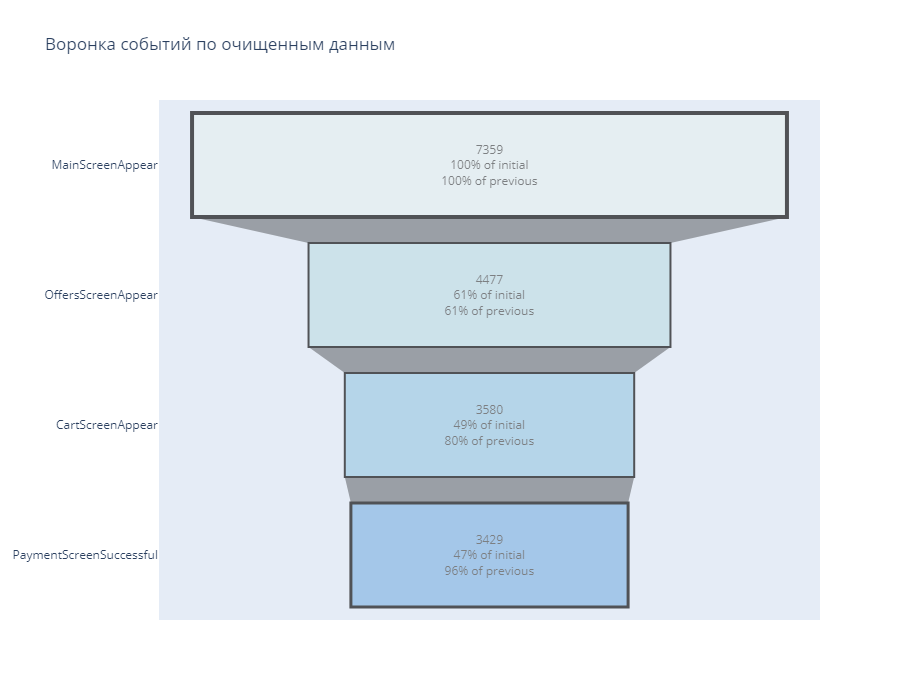

In [30]:
fig = go.Figure(go.Funnel(
    x = events_grouped['id_count'],
    y = events_grouped['event_name'], 
    textinfo = "value+percent previous+percent initial",
    opacity = 0.65, marker = {"color": px.colors.sequential.dense,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "black"}}
    ))
fig.layout = go.Layout(
    title=go.layout.Title(text="Воронка событий по очищенным данным"), width=980, height=700)
fig.show()

Из графика видно, что на первом шаге теряется больше всего пользователей - 39%: при переходе от главного экрана на экран заказа. А до оплаты заказа доходит всего 47% изначальных пользователей.

### Вывод

В этой части мы изучили данные и общее количество событий. Из-за недостаточности данных в начале периода мы отсеяли события до даты 01-Aug-2019.

Также мы изучили какие события присутствуют в наших данных, построили общую воронку событий, убедившись при этом, что в нее попали только пользователи, "начавшие" свой путь с самого первого события. Мы это сделали, чтобы в дальнейшем избежать искажения данных и неверного подсчета долей воронки. Мы исключили из обзора событие `Tutorial`, т.к. оно не является шагом нашей воронки от показа главного экрана до покупки.

Мы смогли показать, что самым критичным шагом является первый шаг, т.е. переход от главного экрана на страницу заказа. 39% пользователей теряются на этой этапе.



## Анализ эксперимента

### Воронка событий с делением по экспериментальным группам

Разделим очищенный датафрейм по экспериментальным группам.

In [31]:
print(f'Всего пользователей:\n в первой A-группе {clean_data.query("exp_id == 246")["device_id_hash"].nunique()};'
     f'\n во второй A-группе {clean_data.query("exp_id == 247")["device_id_hash"].nunique()};'
     f'\n в группе B-теста {clean_data.query("exp_id == 248")["device_id_hash"].nunique()};')

Всего пользователей:
 в первой A-группе 2433;
 во второй A-группе 2452;
 в группе B-теста 2474;


Посмотрим как много пользователей видели каждый экран в каждой группе теста, построим воронку событий для всех групп.

In [32]:
events_grouped = clean_data.groupby(['event_name', 'exp_id'], as_index=False).agg(
    {'device_id_hash': 'nunique', 'exp_id': 'mean'}).sort_values(by='device_id_hash', ascending=False)

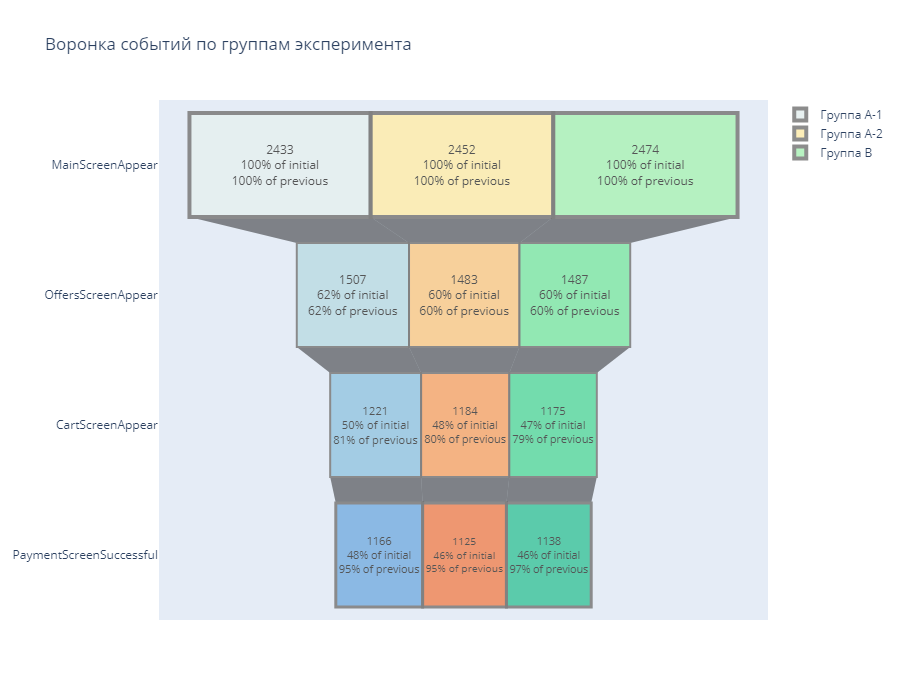

In [33]:
fig = go.Figure()

fig.add_trace(go.Funnel(
    name = 'Группа А-1',
    y=events_grouped[events_grouped['exp_id']==246]['event_name'],
    x=events_grouped[events_grouped['exp_id']==246]['device_id_hash'],
    opacity = 0.9, marker = {"color": px.colors.sequential.dense,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "grey"}},
    textinfo = "value+percent previous+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа А-2',
    y=events_grouped[events_grouped['exp_id']==247]['event_name'],
    x=events_grouped[events_grouped['exp_id']==247]['device_id_hash'],
    textposition = "inside",
    opacity = 0.9, marker = {"color": px.colors.sequential.matter,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "grey"}},
    textinfo = "value+percent previous+percent initial"))

fig.add_trace(go.Funnel(
    name = 'Группа B',
    y=events_grouped[events_grouped['exp_id']==248]['event_name'],
    x=events_grouped[events_grouped['exp_id']==248]['device_id_hash'],
    textposition = "inside",
    opacity = 0.9, marker = {"color": px.colors.sequential.Tealgrn,
    "line": {"width": [4, 2, 2, 3, 1, 1], "color": "grey"}},
    textinfo = "value+percent previous+percent initial"))
fig.layout = go.Layout(
    title=go.layout.Title(text="Воронка событий по группам эксперимента"), width=980, height=700)
fig.show() 

### Статистическое различие между группами 

Сохраним количество событий показа каждого экрана заказа для каждого эксперимента в таблицу. Также создадим объединенную контрольную группу.

In [34]:
ratio_table = (events_grouped
              .pivot(index='event_name', columns='exp_id', values='device_id_hash')
              .sort_values(by=246, ascending=False))
ratio_table.columns = ['A1', 'A2', 'B']
ratio_table['A1+A2'] = ratio_table['A1'] + ratio_table['A2']
ratio_table

,A1,A2,B,A1+A2
event_name,,,,
MainScreenAppear,2433,2452,2474,4885
OffersScreenAppear,1507,1483,1487,2990
CartScreenAppear,1221,1184,1175,2405
PaymentScreenSuccessful,1166,1125,1138,2291


#### Формулировка гипотез

Посчитаем статистические различия между долями показа экранов в наших группах эксперимента. Для этого сформулируем наши гипотезы.

Сформулируем нулевую $ H_0 $ и альтернативную $ H_1 $ гипотезу. <br>
Гипотеза $ H_0 $: доли показа выбранного экрана по отношению к показам главного экрана у двух групп равны; <br>
Гипотеза $ H_1 $: доли показа выбранного экрана по отношению к показам главного экрана у двух групп отличаются.

#### Проверка гипотез

Напишем функцию расчета p-значения и сравнения его с уровнем статистической значимости. Будем использовать z-тест (z-критерий) для разности двух долей в экспериментах.

In [35]:
def z_test(table, columns_list, index_name, alpha=0.05):
    
    share = table.loc[index_name, columns_list]
    total = table.loc['MainScreenAppear', columns_list]
    
    # пропорция успехов в первой группе:
    p1 = share[0]/total[0]

    # пропорция успехов во второй группе:
    p2 = share[1]/total[1]

    # пропорция успехов в комбинированном датасете:
    p_combined = (share[0] + share[1]) / (total[0] + total[1])

    # разница пропорций в датасетах
    difference = p1 - p2     
    
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(
        p_combined * (1 - p_combined) * (1 / total[0] + 1 / total[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = st.norm(0, 1)

    p_value = round(((1 - distr.cdf(abs(z_value))) * 2), 3)
    
    print(f'p-значение для сравнения групп {columns_list[0]} и {columns_list[1]} события `{index_name}`: {p_value}')

    if p_value < alpha:
        print(f'\tОтвергаем нулевую гипотезу: между долями групп есть значимая разница.\n')
    else:
        print(
            f'\tНе получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.\n'
        ) 
    

Проверим гипотезу о равенстве долей двух контрольных групп A1 и A2 по самому популярному событию - `OffersScreenAppear`. Уровень статистической значимости возьмем пока 0.05.

Проверим относительную разницу между количеством пользователей двух контрольных групп.

In [36]:
diff = abs(ratio_table.loc['MainScreenAppear', 'A1'] - ratio_table.loc['MainScreenAppear', 'A2']) / \
    max(ratio_table.loc['MainScreenAppear', 'A1'],
        ratio_table.loc['MainScreenAppear', 'A2'])
print(f'Относительная разница количества пользователей между двумя контрольными группами составит: '
      f'{diff:.2%}')

Относительная разница количества пользователей между двумя контрольными группами составит: 0.77%


Относительная разница между контрольными группами меньше 1%, значит контрольный группы сформированы равномерно и мы можем выполнить A/A тест.

In [37]:
z_test(ratio_table, ['A1', 'A2'], 'OffersScreenAppear')

p-значение для сравнения групп A1 и A2 события `OffersScreenAppear`: 0.295
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Мы смогли показать, что статистического различия между контрольным группами в долях события `OffersScreenAppear` нет. <br>
Теперь проверим гипотезы о равенстве долей контрольных групп для других событий.

In [38]:
for i in ratio_table.index:
    if i not in ['MainScreenAppear', 'OffersScreenAppear']:
        z_test(ratio_table, ['A1', 'A2'], i)

p-значение для сравнения групп A1 и A2 события `CartScreenAppear`: 0.185
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1 и A2 события `PaymentScreenSuccessful`: 0.152
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Теперь посмотрим есть ли статистические различия между долями в контрольных группах и эксперементальной.

In [39]:
for i in ratio_table.index:
    if i not in ['MainScreenAppear']:
        for j in ['A1', 'A2']:
            z_test(ratio_table, [j, 'B'], i)

p-значение для сравнения групп A1 и B события `OffersScreenAppear`: 0.188
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A2 и B события `OffersScreenAppear`: 0.787
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1 и B события `CartScreenAppear`: 0.059
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A2 и B события `CartScreenAppear`: 0.577
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1 и B события `PaymentScreenSuccessful`: 0.176
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A2 и B события `PaymentScreenSuccessful`: 0.934
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Теперь сравним эксперементальную группу с объединенной контрольной группой.

In [40]:
for i in ratio_table.index:
    if i not in ['MainScreenAppear']:
        z_test(ratio_table, ['A1+A2', 'B'], i)

p-значение для сравнения групп A1+A2 и B события `OffersScreenAppear`: 0.36
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1+A2 и B события `CartScreenAppear`: 0.159
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1+A2 и B события `PaymentScreenSuccessful`: 0.465
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.



Мы смогли показать, что по очищенным данным статистической разницы между тремя группами эксперимента у нас нет.

#### Проверка гипотез с учетом поправки Бонферрони

Выше мы смотрели на статистические различия между нашими группами, приняв уровень значимости за `alpha=0.05`. Всего мы проверили 12 гипотез, высока вероятность получить ложноположительной результат. Для того, чтобы снизить эту вероятность уменьшим уровень статистической значимости согласно методу Бонферрони. Выполним более верные расчеты.

In [41]:
bonferroni_alpha = 0.05 / 9

In [42]:
for i in ratio_table.index:
    if i not in ['MainScreenAppear']:
        for j in ['A1', 'A2', 'A1+A2']:
            z_test(ratio_table, [j, 'B'], i, 0.05)

p-значение для сравнения групп A1 и B события `OffersScreenAppear`: 0.188
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A2 и B события `OffersScreenAppear`: 0.787
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1+A2 и B события `OffersScreenAppear`: 0.36
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1 и B события `CartScreenAppear`: 0.059
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A2 и B события `CartScreenAppear`: 0.577
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1+A2 и B события `CartScreenAppear`: 0.159
	Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными.

p-значение для сравнения групп A1 и B события `PaymentScreenSuccessful`

Как и следовало ожидать, при уменьшении уровня значимости результат не изменился. Ни в одном сравнении наших трех групп мы не можем отбросить нашу нулевую гипотезу. Т.е. получаем, что различия между тремя группам эксперимента нет.

### Вывод

В это части мы проанализировали события пользователей в группах нашего A/A/B эксперимента и сравнили доли разных событий относительно изначального для каждой из групп. Мы воспользовались z-тестом для разности двух долей в разных экспериментах.

Мы получили, что разницы в пропорциях разных событий между тремя группами нет. При этом, мы также улучшили расчет, использовав поправку Бонферрони для расчета более верного уровня значимости, т.к. мы сравнимаем несколько групп теста.

## Общий вывод

В этом проекте мы изучили лог событий пользователей мобильного приложения в период с 2019-07-25 по 2019-08-07. В эти даты был выполнен A/A/B тест, в которым мы изучали целесообразность использования новых шрифтов в приложении.

Мы обработали данные, исключив из них дни, в которых событий было недостаточно. Также мы изучили наш набор событий и их воронку, после чего исключили из него событие `Tutorial`, которые не участвует в обычной схеме движения пользователя от главного экрана до покупки. В том числе, мы убрали из лога тех пользователей, которые предположительно попадали на страницу заказа или корзины без показа главного экрана. Мы решили, что такие пользователи могут послужить искажению результата.

В финале, проанализировав сам эксперимент и сформулировав гипотезы, мы сделали расчет статистической значимости между долями разных событий у разных групп эксперимента. Ни в одном сравнении наш тест не показал различия между группами.

То есть мы можем сказать, что введение новых шрифтов в приложении никак не повлияет на увеличение конверсии пользователей.

Рекомендации: в исследовании мы показали, что больше всего пользователей теряется на этапе перехода от главного экрана к странице заказа - стоит обратить на это внимание, возможно что-то не так с дизайном или работой главного экрана нашего приложения.